This example is a breakdown of the test code released with pytorch-CycleGAN-and-pix2pix.  It's less generic - I'm only including the ResNet implementation, and using their default options from the actual code.

### Generator Network

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import numpy as np
import random
import itertools
from collections import OrderedDict

In [2]:
ngpus = 1
batch_size = 1
G_A_checkpoint_file = 'checkpoints/latest_net_G_A.pth'
G_B_checkpoint_file = 'checkpoints/latest_net_G_B.pth'

In [3]:
# Define a resnet block, using reflective padding and InstanceNorm
class ResnetBlock(nn.Module):
    def __init__(self, dim, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, use_bias)
    def build_conv_block(self, dim, use_bias):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [4]:
# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
# Code and idea originally from Justin Johnson's architecture.
# https://github.com/jcjohnson/fast-neural-style/
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64):
        super(ResnetGenerator, self).__init__()
        use_bias = True
        n_downsampling = 2
        n_blocks = 9

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        if ngpus > 1:
            return nn.parallel.data_parallel(self.model, input, range(ngpus))
        return self.model(input)

In [5]:
# create generator network
def define_G(input_nc, output_nc, ngf):
    netG = ResnetGenerator(input_nc, output_nc, ngf)
    return netG

### Image Pool

In [6]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

### CycleGAN

In [7]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

# Converts a Tensor into a Numpy array
# |imtype|: the desired type of the converted numpy array
def tensor2im(image_tensor, imtype=np.uint8):
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return image_numpy.astype(imtype)

In [8]:
class CycleGANModel(object):
    def initialize(self):
        self.nb = 1 # batch size
        self.size = 256 # crop size
        self.input_nc = 3 # number of input channels
        self.output_nc = 3 # number of output channels
        self.ngf = 64 # number of generative filters in the first conv layer
        self.ndf = 64 # number of discriminative filters in the first conv layer
        self.pool_size = 50 # size of image buffer that stores previously generated images
        self.lr = 0.0002 # initial learning rate for Adam
        self.old_lr = 0.0002 # initial learning rate for Adam
        self.beta1 = 0.5 # momentum term for Adam
        self.identity = 0.0 # use identity mapping. Setting identity other than 1 has an effect of scaling the weight of the identity mapping loss. For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set optidentity = 0.1
        self.lambda_A = 10.0 # weight for cycle loss (A -> B -> A)
        self.lambda_B = 10.0 # weight for cycle loss (B -> A -> B)
        self.checkpoint_dir = 'checkpoints'
        
        # inputs
        self.input_A = torch.FloatTensor(self.nb, self.input_nc, self.size, self.size)
        self.input_B = torch.FloatTensor(self.nb, self.output_nc, self.size, self.size)

        # generators
        self.netG_A = define_G(self.input_nc, self.output_nc, self.ngf)
        self.netG_B = define_G(self.output_nc, self.input_nc, self.ngf)
        print('Loading weights for generators')
        self.netG_A.load_state_dict(torch.load(G_A_checkpoint_file))
        self.netG_B.load_state_dict(torch.load(G_B_checkpoint_file))
        if torch.cuda.is_available():
            self.netG_A.cuda()
            self.netG_B.cuda()

        print('---------- Networks initialized -------------')
        print_network(self.netG_A)
        print_network(self.netG_B)
        print('-----------------------------------------------')

    def set_input(self, input):
        input_A = input['A']
        input_B = input['B']
        self.input_A.resize_(input_A.size()).copy_(input_A)
        self.input_B.resize_(input_B.size()).copy_(input_B)
        self.image_paths = input['A_paths']

    def test(self):
        self.real_A = Variable(self.input_A, volatile=True)
        self.real_B = Variable(self.input_B, volatile=True)
        if torch.cuda.is_available():
            self.real_A = self.real_A.cuda()
            self.real_B = self.real_B.cuda()

        self.fake_B = self.netG_A.forward(self.real_A)
        self.rec_A = self.netG_B.forward(self.fake_B)

        self.fake_A = self.netG_B.forward(self.real_B)
        self.rec_B = self.netG_A.forward(self.fake_A)

    # get image paths
    def get_image_paths(self):
        return self.image_paths

    def get_current_visuals(self):
        real_A = tensor2im(self.real_A.data)
        fake_B = tensor2im(self.fake_B.data)
        rec_A = tensor2im(self.rec_A.data)
        real_B = tensor2im(self.real_B.data)
        fake_A = tensor2im(self.fake_A.data)
        rec_B = tensor2im(self.rec_B.data)
        if self.identity > 0.0:
            idt_A = tensor2im(self.idt_A.data)
            idt_B = tensor2im(self.idt_B.data)
            return OrderedDict([('real_A', real_A), ('fake_B', fake_B), ('rec_A', rec_A), ('idt_B', idt_B),
                                ('real_B', real_B), ('fake_A', fake_A), ('rec_B', rec_B), ('idt_A', idt_A)])
        else:
            return OrderedDict([('real_A', real_A), ('fake_B', fake_B), ('rec_A', rec_A),
                                ('real_B', real_B), ('fake_A', fake_A), ('rec_B', rec_B)])
    def backward_G(self):
        lambda_idt = self.identity
        lambda_A = self.lambda_A
        lambda_B = self.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed.
            self.idt_A = self.netG_A.forward(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed.
            self.idt_B = self.netG_B.forward(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss
        # D_A(G_A(A))
        self.fake_B = self.netG_A.forward(self.real_A)
        pred_fake = self.netD_A.forward(self.fake_B)
        self.loss_G_A = self.criterionGAN(pred_fake, True)
        # D_B(G_B(B))
        self.fake_A = self.netG_B.forward(self.real_B)
        pred_fake = self.netD_B.forward(self.fake_A)
        self.loss_G_B = self.criterionGAN(pred_fake, True)
        # Forward cycle loss
        self.rec_A = self.netG_B.forward(self.fake_B)
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss
        self.rec_B = self.netG_A.forward(self.fake_A)
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()

In [9]:
model = CycleGANModel()
model.initialize()

Loading weights for generators
---------- Networks initialized -------------
ResnetGenerator (
  (model): Sequential (
    (0): ReflectionPad2d (3, 3, 3, 3)
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
    (3): ReLU (inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    (6): ReLU (inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (9): ReLU (inplace)
    (10): ResnetBlock (
      (conv_block): Sequential (
        (0): ReflectionPad2d (1, 1, 1, 1)
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
        (3): ReLU (inplace)
        (4): ReflectionPad2d (1, 1, 1, 1)
        (5): Conv2d(256, 256, kernel_size=(3, 3), s

### Test Data

In [10]:
%%bash
if [ ! -d datasets/maps ]; then
./datasets/download_cyclegan_dataset.sh maps
fi

In [11]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
from glob import glob

class MapsDataset(Dataset):
    def __init__(self, mode):
        self.img_paths_A = glob(os.path.join('datasets/maps', mode+'A', '*.jpg'))
        self.img_paths_B = glob(os.path.join('datasets/maps', mode+'B', '*.jpg'))
        self.img_paths_A = sorted(self.img_paths_A)
        self.img_paths_B = sorted(self.img_paths_B)
        self.A_size = len(self.img_paths_A)
        self.B_size = len(self.img_paths_B)
        self.dataset_size = max(self.A_size, self.B_size)
        self.transform = self.get_transform()
        
    def __getitem__(self, index):
        index_A = index % self.A_size
        index_B = random.randint(0, self.B_size-1)
        
        img_path_A = self.img_paths_A[index_A]
        img_path_B = self.img_paths_B[index_B]
        
        raw_img_A = Image.open(img_path_A).convert('RGB')
        raw_img_B = Image.open(img_path_B).convert('RGB')
        img_A = self.transform(raw_img_A)
        img_B = self.transform(raw_img_B)
        
        return {'A': img_A, 'B': img_B, 
                'A_paths': img_path_A, 'B_paths': img_path_B,
                'raw_A': np.asarray(raw_img_A), 'raw_B': np.asarray(raw_img_B)}
    
    def __len__(self):
        return self.dataset_size
    
    def get_transform(self):
        load_size = 286
        fine_size = 256
        transform_list = [transforms.Scale((load_size, load_size), Image.BICUBIC),
                          transforms.RandomCrop(fine_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
        
    def name(self):
        return "MapsDataset"

In [12]:
maps_dataset = MapsDataset('test')
maps_dataloader = DataLoader(maps_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print('Number of training images: ' + str(len(maps_dataloader)))

Number of training images: 1098


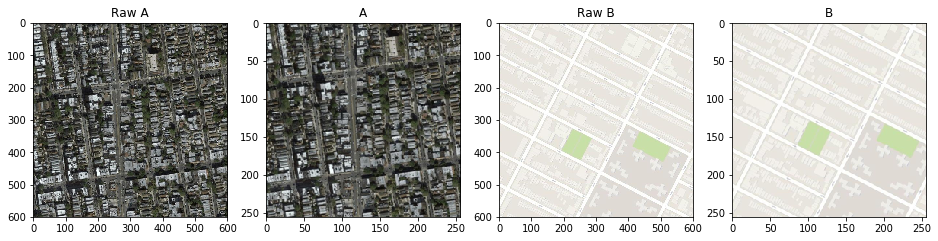

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def unnorm(x):
    un_x = 255*(x*0.5+0.5)
    return un_x.astype(np.uint8)

# visualize to check images
test_datum = next(iter(maps_dataloader))
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(test_datum['raw_A'][0].numpy())
plt.title('Raw A')
plt.subplot(1,4,2)
plt.imshow(unnorm(test_datum['A'][0].numpy()).transpose(1,2,0))
plt.title('A')
plt.subplot(1,4,3)
plt.imshow(test_datum['raw_B'][0].numpy())
plt.title('Raw B')
plt.subplot(1,4,4)
plt.imshow(unnorm(test_datum['B'][0].numpy()).transpose(1,2,0))
plt.title('B')

### Run Test

In [14]:
model.set_input(test_datum)
model.test()
vis = model.get_current_visuals()

In [15]:
vis.keys()

odict_keys(['real_A', 'fake_B', 'rec_A', 'real_B', 'fake_A', 'rec_B'])

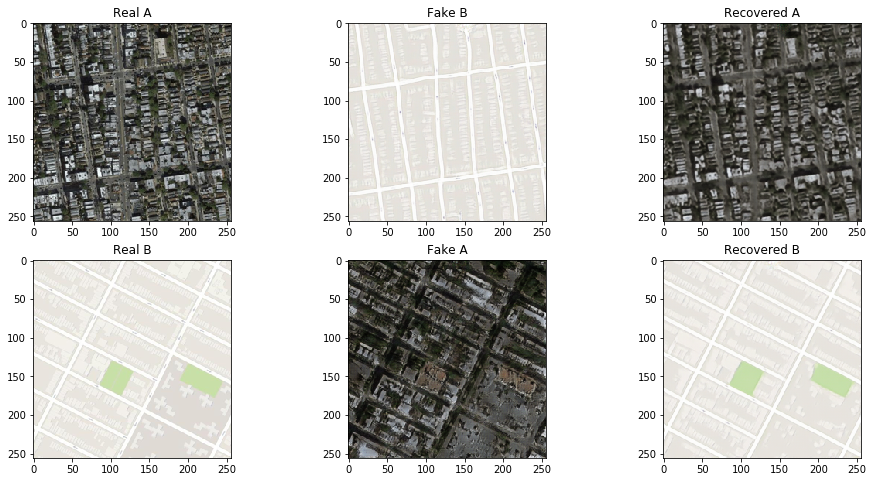

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.imshow(vis['real_A'])
plt.title('Real A')
plt.subplot(2,3,2)
plt.imshow(vis['fake_B'])
plt.title('Fake B')
plt.subplot(2,3,3)
plt.imshow(vis['rec_A'])
plt.title('Recovered A')
plt.subplot(2,3,4)
plt.imshow(vis['real_B'])
plt.title('Real B')
plt.subplot(2,3,5)
plt.imshow(vis['fake_A'])
plt.title('Fake A')
plt.subplot(2,3,6)
plt.imshow(vis['rec_B'])
plt.title('Recovered B')